In [1]:
"""
Author: Vinay Narayana
"""
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# imports for preprocessing
import re
import nltk
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# import swifter


# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# training
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection  import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# to serialize/ pickle objects
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# constants

DATA_DIR = "./data/"
INPUT_FILE = "sample30.csv"

COLS_REQUIRED = ['id','name', 'reviews_text', 'user_sentiment', 'reviews_rating']

### Data Loading

In [3]:
df_reviews = pd.read_csv(DATA_DIR+INPUT_FILE)
print(df_reviews.shape)
df_reviews.head(2)

(30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


## Data Cleaning
### Exploratory Data Analysis

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
def missingValues(df, thresh=0):
    df_nas_percent = (
            ((df.isna().sum()/df.shape[0])*100)
            .reset_index()
            .rename(columns={"index": "column", 0: "nulls_percent"})
            .sort_values(by="nulls_percent", ascending=False)
    )
    return df_nas_percent.loc[df_nas_percent["nulls_percent"] > thresh]

missingValues(df_reviews)

,column,nulls_percent
12,reviews_userProvince,99.433333
11,reviews_userCity,93.570000
6,reviews_didPurchase,46.893333
7,reviews_doRecommend,8.566667
10,reviews_title,0.633333
3,manufacturer,0.470000
13,reviews_username,0.210000
5,reviews_date,0.153333
14,user_sentiment,0.003333


In [6]:
df_reviews.isna().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [7]:
# df_reviews = reviews[COLS_REQUIRED].copy(deep=True)
# df_reviews = reviews.copy(deep=True)
# user_sentiment - NULL fix
df_reviews = df_reviews[~df_reviews.user_sentiment.isna()].copy()
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})
df_reviews.shape

(29999, 15)

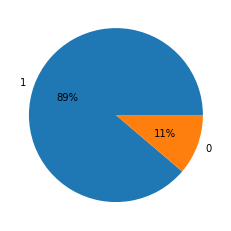

In [8]:
# sns_colors = sns.color_palette("Spectral")
user_senti_counts = df_reviews['user_sentiment'].value_counts()
plt.pie(user_senti_counts, labels=user_senti_counts.index.tolist(), autopct='%.0f%%')
plt.show()

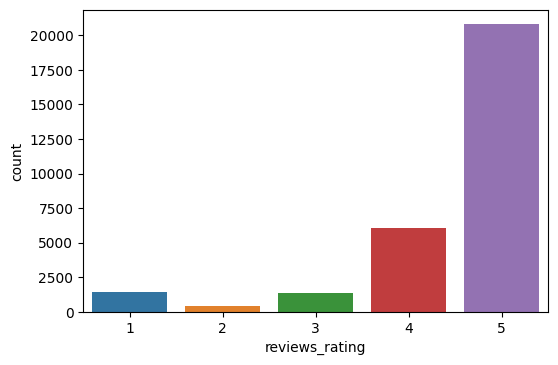

In [9]:
plt.figure(dpi=100)
_ = sns.countplot(x=df_reviews['reviews_rating'])
plt.show()

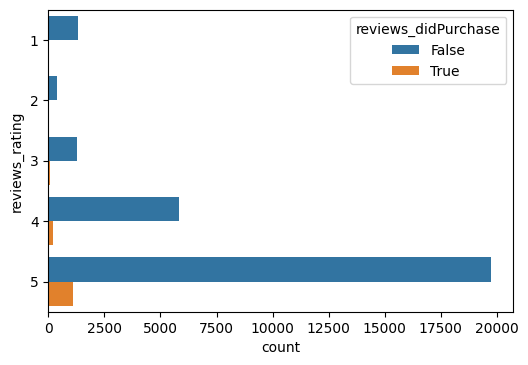

In [10]:
plt.figure(dpi=100)
sns.countplot(y=df_reviews['reviews_rating'], hue=df_reviews["reviews_didPurchase"].fillna(False))
plt.show()

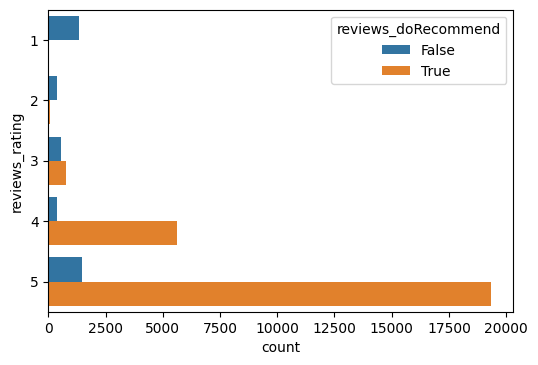

In [11]:
plt.figure(dpi=100)
sns.countplot(y=df_reviews['reviews_rating'], hue=df_reviews["reviews_doRecommend"].fillna(False))
plt.show()

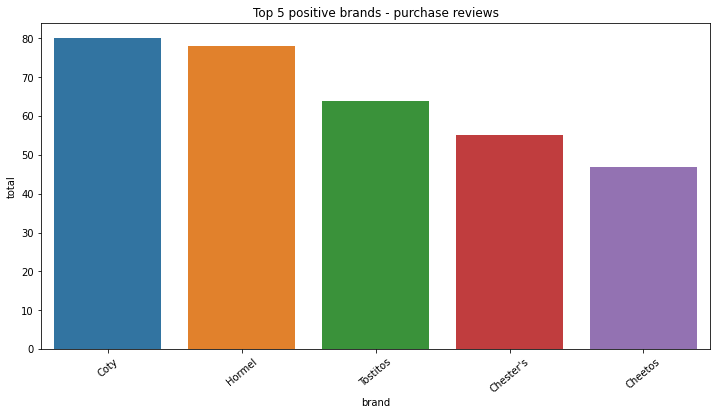

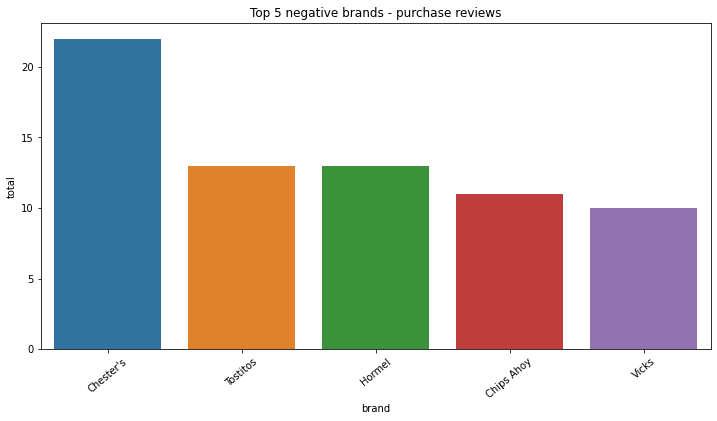

In [12]:
N = 5

purchased_reviews = df_reviews.loc[df_reviews['reviews_didPurchase']==True]
purchased_reviews_by_brand_sentiment = purchased_reviews[['brand', 'user_sentiment']].value_counts().reset_index().rename(columns={0:"total"})
positive_brands = purchased_reviews_by_brand_sentiment[purchased_reviews_by_brand_sentiment['user_sentiment']==1].sort_values(by="total", ascending=False)
negative_brands = purchased_reviews_by_brand_sentiment[purchased_reviews_by_brand_sentiment['user_sentiment']==0].sort_values(by="total", ascending=False)

plt.figure(figsize=(12, 6))
plt.title(f"Top {N} positive brands - purchase reviews")
sns.barplot(data=positive_brands[:N], x='brand', y='total')
plt.xticks(rotation=40)
plt.show()

plt.figure(figsize=(12, 6))
plt.title(f"Top {N} negative brands - purchase reviews")
sns.barplot(data=negative_brands[:N], x='brand', y='total')
plt.xticks(rotation=40)
plt.show()

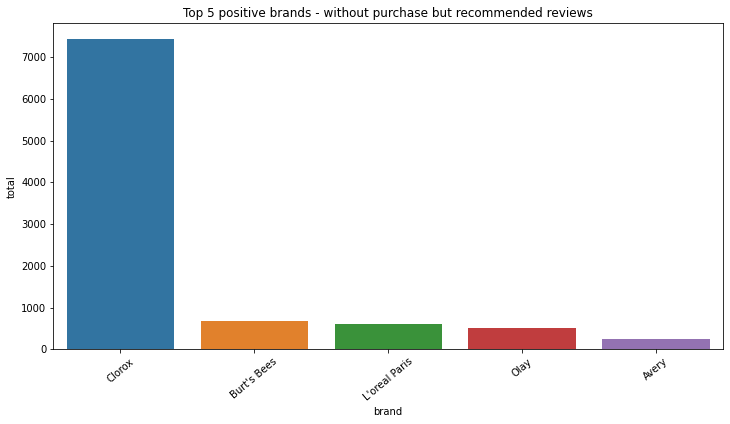

In [13]:
recommended_reviews_without_purchase = df_reviews.loc[(df_reviews['reviews_didPurchase']==False) & (df_reviews['reviews_doRecommend']==True)]
recommend_rwp_brand_sentiment = recommended_reviews_without_purchase[['brand', 'user_sentiment']].value_counts().reset_index().rename(columns={0:"total"})
recommend_rwp_positive = recommend_rwp_brand_sentiment[recommend_rwp_brand_sentiment['user_sentiment']==1].sort_values(by="total", ascending=False)

plt.figure(figsize=(12, 6))
plt.title(f"Top {N} positive brands - without purchase but recommended reviews")
sns.barplot(data=recommend_rwp_positive[:N], x='brand', y='total')
plt.xticks(rotation=40)
plt.show()

In [14]:
from wordcloud import WordCloud, STOPWORDS

def generate_wc(data, title=None, words=30):
    if len(data) < 1:
        print("No words to generate word cloud")
        return
    if type(data) is pd.Series:
        data = "\n".join(list(data.values))
    wordcloud = WordCloud(
        background_color="black",
        width=3000,
        height=2000,
        max_words=40,
        random_state=23,
        stopwords = set(STOPWORDS),
        colormap='Set2',
        collocations=False
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        plt.title(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

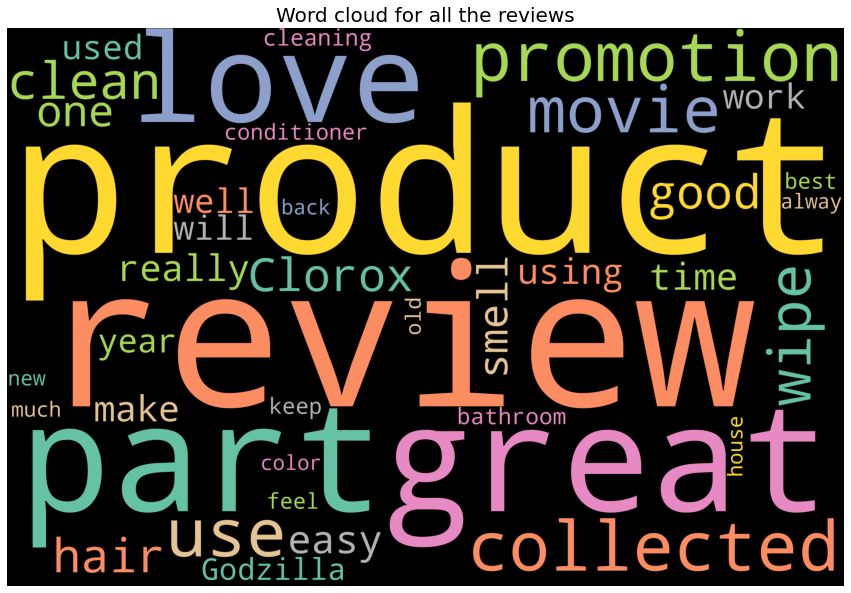

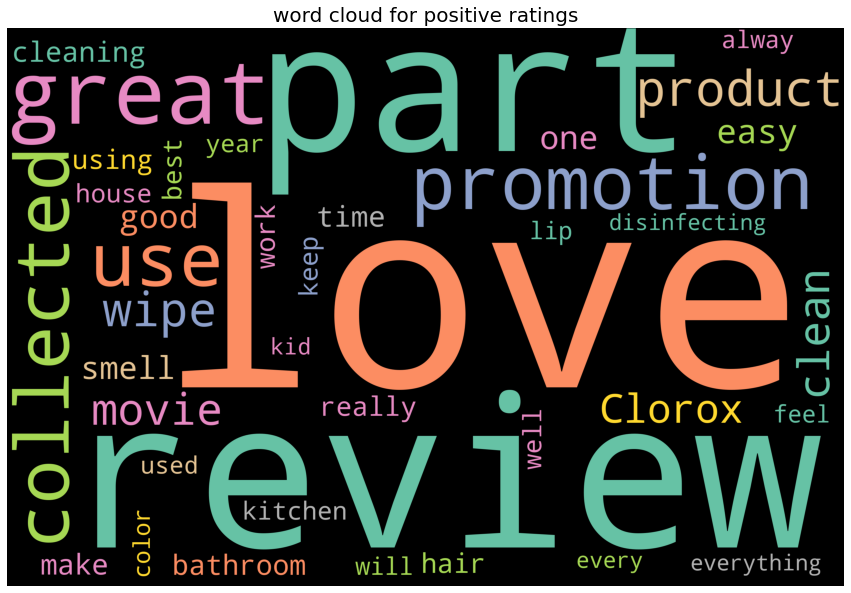

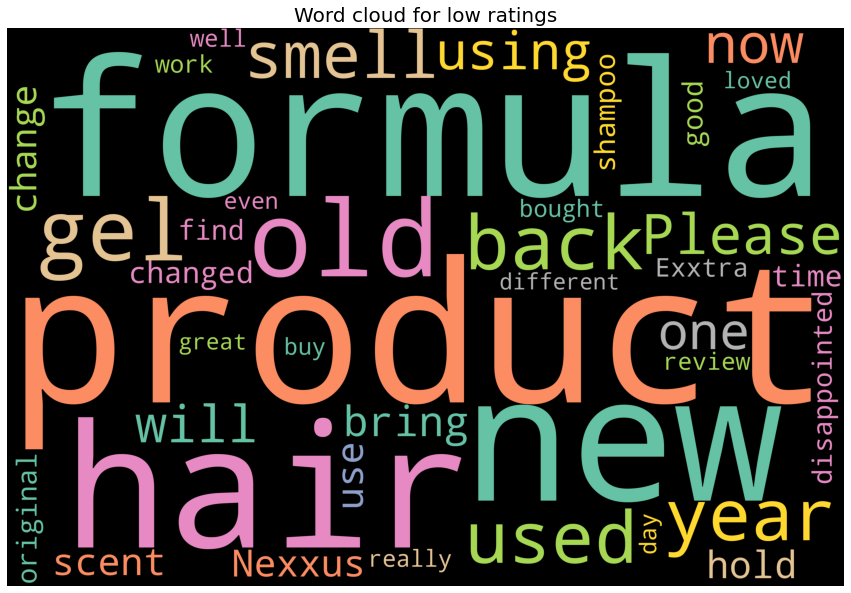

In [15]:
generate_wc(df_reviews['reviews_text'], title="Word cloud for all the reviews", words=50)
generate_wc(df_reviews[df_reviews['reviews_rating']>4]['reviews_text'], title="word cloud for positive ratings", words=30)
generate_wc(df_reviews.loc[df_reviews['reviews_rating']<2]['reviews_text'], title="Word cloud for low ratings", words=30)

In [16]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"])

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
0,597,140,220,550,1860
1,787,280,1125,5470,18970


### Text Preprocessing

In [17]:
# !python -m spacy download en_core_web_sm

In [18]:
# !pip install -q swifter

In [19]:
# nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [20]:
# preprocessing functions
# remove stop words
def remove_stopwords(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)


def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)
    return text

# function to clean the texts
# def clean_text(text):
#     '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
#     text = text.lower()
#     text = re.sub(r'\[.*?\]', '', text)
#     text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub(r'\w*\d\w*', '', text)
#     # text = remove_stopwords(text)
#     return text


# function to Lemmatize the texts
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     processed_text = " ".join(sent)
#     processed_text = processed_text.replace("-PROPN-", "")
#     return processed_text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
lemmatizer = WordNetLemmatizer()

def lemmatized_text(text):
    """Get position tags and lemmatize the words/ tokens"""
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopwords(text)))
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

In [21]:
df_reviews["reviews_title"]= df_reviews["reviews_title"].fillna('')
df_reviews["review_full_text"]=df_reviews[["reviews_title","reviews_text"]].agg(". ".join, axis=1).str.lstrip('. ')

# df_reviews['cleaned_reviews'] = df_reviews.swifter.apply(lambda x: clean_text(x['review_full_text']), axis=1)
# df_reviews['lemmatized_reviews'] = df_reviews.swifter.apply(lambda x: lemmatized_text(x['cleaned_reviews']), axis=1)

df_reviews['cleaned_reviews'] = df_reviews.apply(lambda x: clean_text(x['review_full_text']), axis=1)
df_reviews['lemmatized_reviews'] = df_reviews.apply(lambda x: lemmatized_text(x['cleaned_reviews']), axis=1)

df_reviews.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_full_text,cleaned_reviews,lemmatized_reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,1,Just Awesome. i love this album. it's very goo...,just awesome i love this album its very good m...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,1,Good. Good flavor. This review was collected a...,good good flavor this review was collected as ...,good good flavor review collect part promotion


In [22]:
COLS_REQUIRED += ['lemmatized_reviews']
df_reviews = df_reviews[COLS_REQUIRED]
df_reviews.head(2)

,id,name,reviews_text,user_sentiment,reviews_rating,lemmatized_reviews
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,1,5,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,1,5,good good flavor review collect part promotion


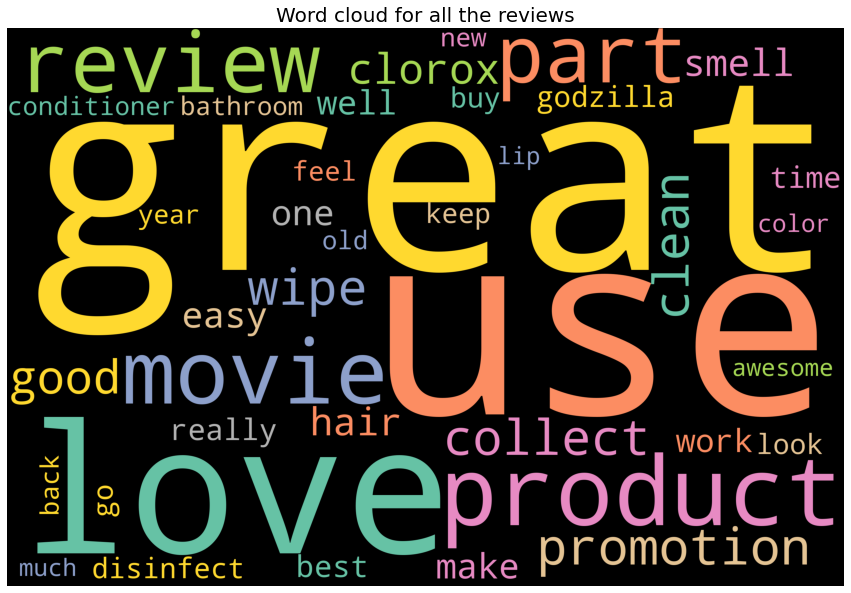

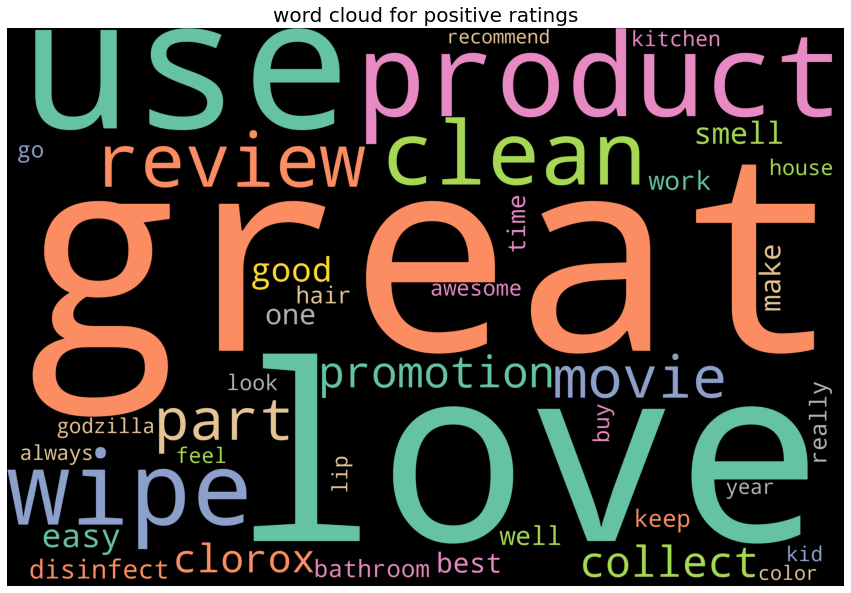

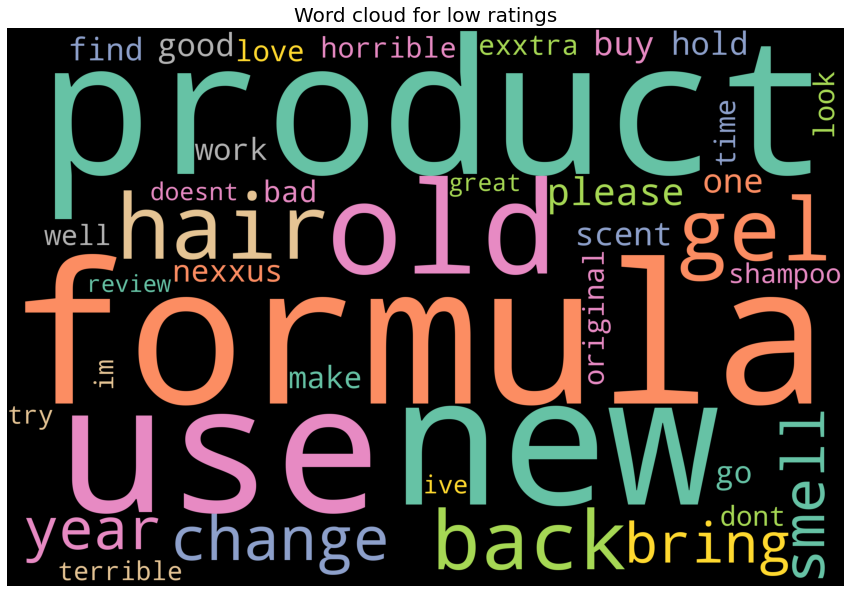

In [23]:
# implement EDA/ word cloud, ngram etc
generate_wc(df_reviews['lemmatized_reviews'], title="Word cloud for all the reviews", words=50)
generate_wc(df_reviews[df_reviews['reviews_rating']>4]['lemmatized_reviews'], title="word cloud for positive ratings", words=30)
generate_wc(df_reviews.loc[df_reviews['reviews_rating']<2]['lemmatized_reviews'], title="Word cloud for low ratings", words=30)

In [24]:
def top_N_grams(text, ngram_range=(1, 1), n=30):
    c_vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text)
    bag_of_words = c_vec.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)

    word_frequency = [(word, sum_of_words[0, idx]) for word, idx in c_vec.vocabulary_.items()]
    return sorted(word_frequency, key = lambda x: x[1], reverse=True)[:n]

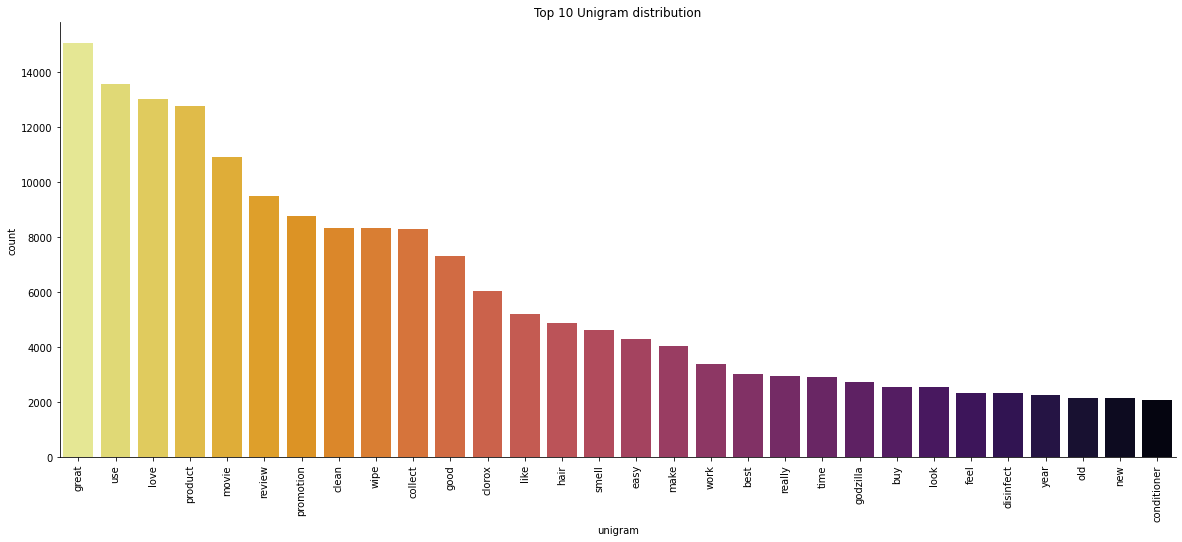

In [25]:
#Print the top 10 words in the unigram frequency
top_30_unigrams = top_N_grams(df_reviews['lemmatized_reviews'].values.astype('U'))
df_unigrams = pd.DataFrame(top_30_unigrams, columns=['unigram', 'count'])
# df_unigrams.head(10)
plt.figure(figsize=(20, 8))
sns.barplot(data=df_unigrams, x='unigram', y='count', palette="inferno_r")
sns.despine()
plt.tick_params(axis='x', rotation=90)
_ = plt.title("Top 10 Unigram distribution")

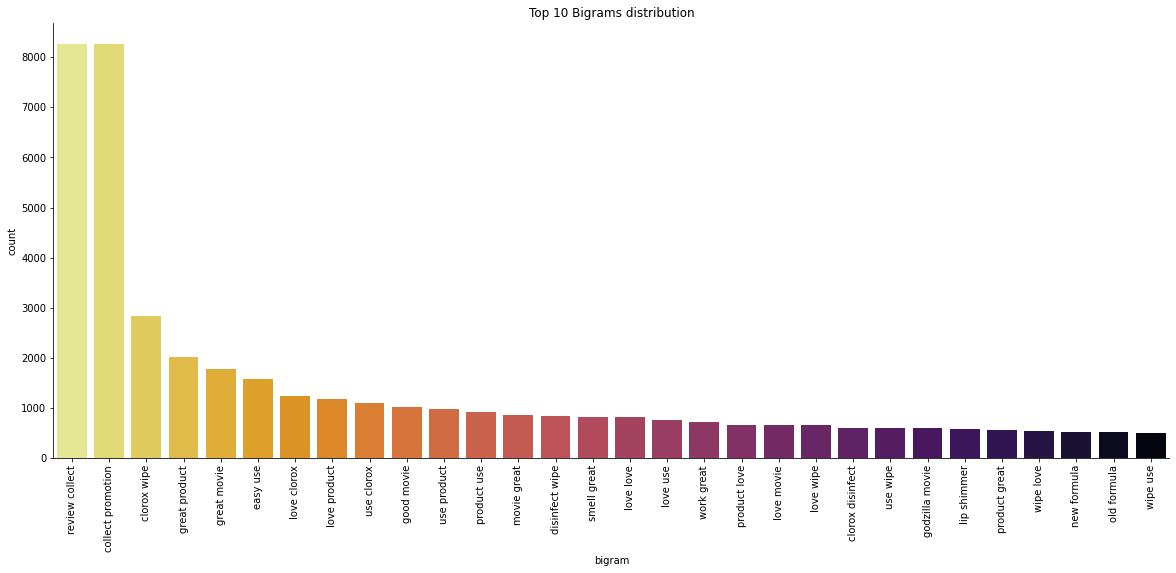

In [26]:
#Print the top 10 words in the bigram frequency
top_30_bigrams = top_N_grams(df_reviews['lemmatized_reviews'].values.astype('U'), ngram_range=(2,2))
df_bigrams = pd.DataFrame(top_30_bigrams, columns=['bigram', 'count'])
# df_bigrams.head(10)
plt.figure(figsize=(20, 8))
sns.barplot(data=df_bigrams, x='bigram', y='count', palette="inferno_r")
sns.despine()
plt.tick_params(axis='x', rotation=90)
_ = plt.title("Top 10 Bigrams distribution")

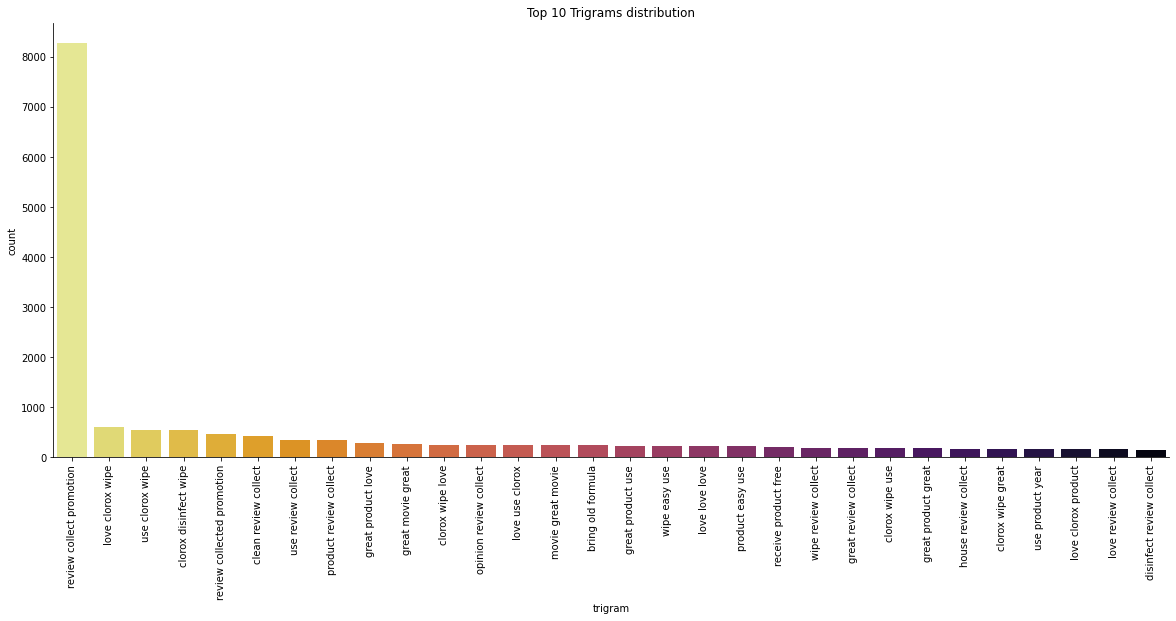

In [27]:
#Print the top 10 words in the bigram frequency
top_30_trigrams = top_N_grams(df_reviews['lemmatized_reviews'].values.astype('U'), ngram_range=(3,3))
df_trigrams = pd.DataFrame(top_30_trigrams, columns=['trigram', 'count'])


plt.figure(figsize=(20, 8))
sns.barplot(data=df_trigrams, x='trigram', y='count', palette="inferno_r")
sns.despine()
plt.tick_params(axis='x', rotation=90)
_ = plt.title("Top 10 Trigrams distribution")

In [28]:
df_reviews.columns

Index(['id', 'name', 'reviews_text', 'user_sentiment', 'reviews_rating',
       'lemmatized_reviews'],
      dtype='object')

In [29]:
df_reviews.shape

(29999, 6)

### Feature Extraction

In [30]:
X = df_reviews['lemmatized_reviews']
y = df_reviews['user_sentiment']

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=600, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,3))

# create the Document Term Matrix by transforming the lemmatized.
tfidf = tfidf_vectorizer.fit_transform(X)

features = tfidf_vectorizer.get_feature_names()
pd.DataFrame(tfidf.toarray(), columns = features).head(2)

,able,absolutely,absolutely love,act,action,actor,actually,add,age,ago,...,work great,worry,worth,wouldnt,wrong,year,year old,yes,young,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training

In [31]:
# y = df_reviews['user_sentiment']
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, random_state=42, test_size=0.3)#, stratify=y)

In [32]:
counter = Counter(y_train)
print('Before --->', counter)
sm = SMOTE()
# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After --->',counter)

Before ---> Counter({1: 18599, 0: 2400})
After ---> Counter({0: 18599, 1: 18599})


In [33]:
class ModelBuilder:
    __separator = "__"*30
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print(self.__separator)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print(self.__separator)
        print("\n")
        
        self.classification_report(y_pred_class)
        print(self.__separator)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print(self.__separator)
        print("\n")
        
        metrics.plot_roc_curve(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))



____________________________________________________________
Accuracy is : 85.8%
Precision is : 95.6%
Recall is : 88.2%
F1 Score is : 91.7%
Roc-Auc Score is:88.3%
____________________________________________________________


              precision    recall  f1-score   support

           0       0.40      0.66      0.50       967
           1       0.96      0.88      0.92      8033

    accuracy                           0.86      9000
   macro avg       0.68      0.77      0.71      9000
weighted avg       0.90      0.86      0.87      9000

____________________________________________________________




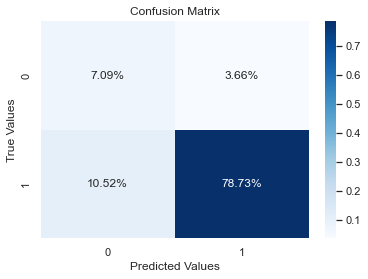

____________________________________________________________


CPU times: total: 188 ms
Wall time: 292 ms


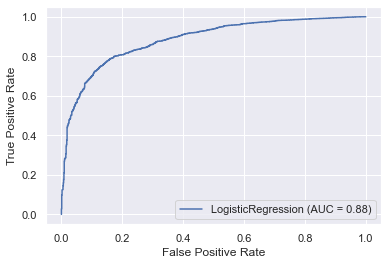

In [34]:
%%time
logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)



____________________________________________________________
Accuracy is : 78.8%
Precision is : 95.7%
Recall is : 79.9%
F1 Score is : 87.1%
Roc-Auc Score is:83.2%
____________________________________________________________


              precision    recall  f1-score   support

           0       0.30      0.70      0.42       967
           1       0.96      0.80      0.87      8033

    accuracy                           0.79      9000
   macro avg       0.63      0.75      0.64      9000
weighted avg       0.89      0.79      0.82      9000

____________________________________________________________




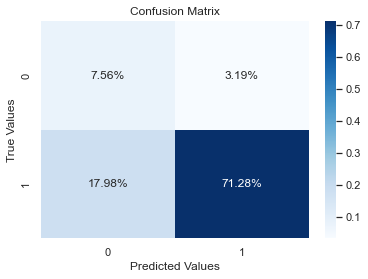

____________________________________________________________


CPU times: total: 109 ms
Wall time: 171 ms


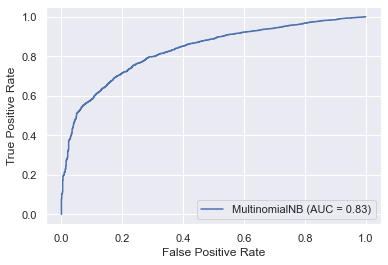

In [35]:
%%time
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)

y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)



____________________________________________________________
Accuracy is : 80.4%
Precision is : 94.3%
Recall is : 83.1%
F1 Score is : 88.3%
Roc-Auc Score is:76.8%
____________________________________________________________


              precision    recall  f1-score   support

           0       0.29      0.58      0.39       967
           1       0.94      0.83      0.88      8033

    accuracy                           0.80      9000
   macro avg       0.62      0.71      0.64      9000
weighted avg       0.87      0.80      0.83      9000

____________________________________________________________




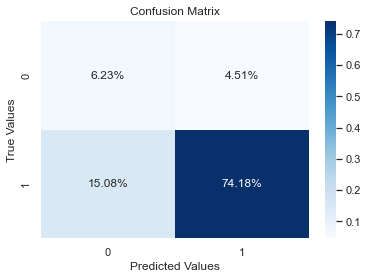

____________________________________________________________


CPU times: total: 344 ms
Wall time: 955 ms


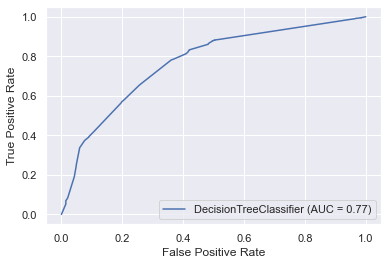

In [36]:
%%time

dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)

y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

In [37]:
# rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")
# params = {
#     'max_depth': [2,3,5,10],
#     'min_samples_leaf': [5,10,20,50],
#     'n_estimators': [10, 25, 50, 100]
# }
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=params,
#                            cv = 4,
#                            n_jobs=-1,
#                            verbose=1,
#                            scoring="f1"
#             )

In [38]:
# %%time
# grid_search.fit(X_train, y_train)



____________________________________________________________
Accuracy is : 79.1%
Precision is : 95.0%
Recall is : 80.9%
F1 Score is : 87.4%
Roc-Auc Score is:81.7%
____________________________________________________________


              precision    recall  f1-score   support

           0       0.29      0.64      0.40       967
           1       0.95      0.81      0.87      8033

    accuracy                           0.79      9000
   macro avg       0.62      0.73      0.64      9000
weighted avg       0.88      0.79      0.82      9000

____________________________________________________________




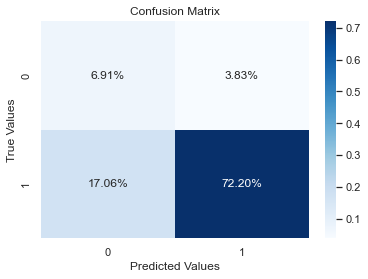

____________________________________________________________




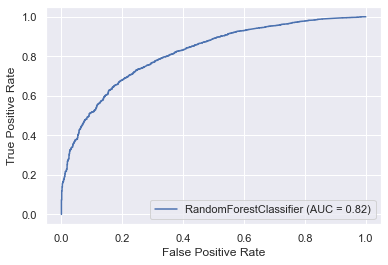

In [39]:
# rf_best = grid_search.best_estimator_
rf_best = RandomForestClassifier(max_depth=10, min_samples_leaf=5, oob_score=True, random_state=42)
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)

y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

In [40]:
# rf_best

In [41]:
# !pip install xgboost

In [42]:
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

In [43]:
folds= KFold(n_splits=5, shuffle=True, random_state=42)
params={ 'learning_rate':[0.001,0.003,0.01,0.03,0.1,0.3]}
# params = {
#         'learning_rate':[0.01,0.1,0.3],
#     'max_depth': [10],
#     # 'min_samples_leaf': [5,10,20,50],
#     'n_estimators': [10, 25, 50, 100]
# }

In [44]:
xgb_clf = xgb.XGBClassifier(eval_metric='auc', objective="binary:logistic")#, tree_method='gpu_hist',predictor = 'gpu_predictor')
tuner=GridSearchCV(estimator=xgb_clf, param_grid=params, 
    cv=folds, 
    scoring="f1", return_train_score=True, verbose=1)#, n_jobs=-1)
tuner.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   60.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     in...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
          

In [45]:
tuner.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)



____________________________________________________________
Accuracy is : 87.7%
Precision is : 94.7%
Recall is : 91.3%
F1 Score is : 93.0%
Roc-Auc Score is:88.0%
____________________________________________________________


              precision    recall  f1-score   support

           0       0.44      0.58      0.50       967
           1       0.95      0.91      0.93      8033

    accuracy                           0.88      9000
   macro avg       0.70      0.75      0.72      9000
weighted avg       0.89      0.88      0.88      9000

____________________________________________________________




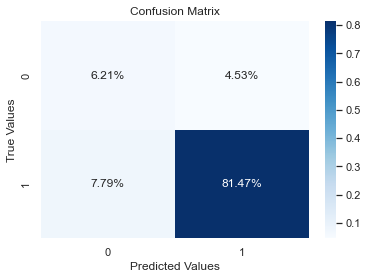

____________________________________________________________




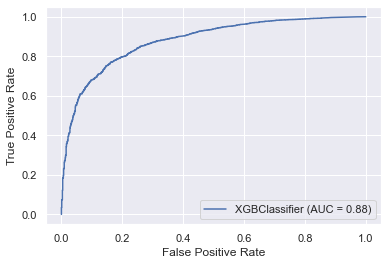

In [46]:
# xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42, tree_method='gpu_hist',predictor = 'gpu_predictor') #based on the tuned parameters
xgclf = tuner.best_estimator_
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)

y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [47]:
xg_metrics

[0.8767777777777778,
 0.9472868217054263,
 0.9127349682559442,
 0.9296899765421923,
 0.8795700027974059]

In [48]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'], 
                'Logistic Regression': lr_metrics,
                'Naive Bayes': nb_metrics,
                'Decision Tree': dt_metrics_cv,
                'Random Forrest': rf_metrics,
                'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.858222,0.788333,0.804111,0.791111,0.876778
1,Precision,0.955630,0.957177,0.942672,0.949584,0.947287
2,Recall,0.882111,0.798581,0.831072,0.808913,0.912735
3,F1Score,0.917400,0.870716,0.883361,0.873622,0.929690
4,Auc Score,0.883372,0.832011,0.767572,0.817256,0.879570


In [51]:
def save_object(obj, filename):
    filename = "./models/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [52]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')
save_object(tfidf_vectorizer, 'tfidf-vectorizer')
save_object(df_reviews, 'cleaned-data')

## Recommendation System

In [55]:
DATA_DIR = "./data/"
INPUT_FILE = "sample30.csv"

RECOMMENDATION_COLS = ["id", "name", "reviews_rating", "reviews_username"]
df_reviews = pd.read_csv(DATA_DIR+INPUT_FILE)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [56]:
df_reviews = df_reviews[~df_reviews.reviews_username.isna()]
df_reviews =  df_reviews.loc[~df_reviews.user_sentiment.isna()]

In [57]:
df_recommendation = df_reviews[RECOMMENDATION_COLS]
print((df_recommendation.isna().sum()/df_recommendation.shape[0])*100)
df_recommendation.shape

id                  0.0
name                0.0
reviews_rating      0.0
reviews_username    0.0
dtype: float64


(29936, 4)

In [58]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)
print(train.shape)
print(test.shape)

(22452, 4)
(7484, 4)


In [59]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [60]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.11E+24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [62]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
27954,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,5,silvahalo
3375,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,4,stacberg
20192,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,erwerw
457,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,olay53
19060,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,nicelady


In [63]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [64]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
09mommy11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.11E+24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### User Similarity Matrix

In [65]:
df_pivot.index.nunique()

19427

In [66]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]
(19427, 19427)


#### Prediction user-user

In [67]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [68]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.20913332, ..., 2.9103958 , 0.        ,
        0.54410719],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 1.64034869, 0.        ,
        0.57353933],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135]])

In [69]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,1.209133,13.576034,0.0,0.0,0.0,2.256552,0.440415,3.136671,...,0.449467,0.422577,0.000000,0.0,0.0,0.0,2.121320,2.910396,0.0,0.544107
01impala,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02dakota,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02deuce,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
0325home,0.0,0.0,0.000000,11.344965,0.0,0.0,0.0,6.010227,6.937603,2.097953,...,0.000000,0.445435,3.535534,0.0,0.0,0.0,2.236068,0.000000,0.0,2.886751


#### top 20 recommendations for the user

In [70]:
user_input = "melkschefft" 
print(user_input)

recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

melkschefft


id
AVpfPaoqLJeJML435Xk9    9.041098
AV1YGDqsGV-KLJ3adc-O    7.071068
AVpf3VOfilAPnD_xjpun    6.422285
AVpfJP1C1cnluZ0-e3Xy    5.549968
AVpe41TqilAPnD_xQH3d    4.524296
AVpfM_ytilAPnD_xXIJb    3.535534
AV1l8zRZvKc47QAVhnAv    3.535534
AVpf2tw1ilAPnD_xjflC    3.535534
AVpf5FF71cnluZ0-tHAV    3.535534
AV1Ymf_rglJLPUi8II2v    3.086067
AV1ZT7GLglJLPUi8IQLI    3.077287
AVpfMpZ51cnluZ0-f_L9    2.461830
AVpfR5m0LJeJML436K3W    2.364625
AVpf63aJLJeJML43F__Q    2.159671
AVpfGuDrLJeJML432fDz    2.159671
AVpfBrUZilAPnD_xTUly    2.159671
AVpfm8yiLJeJML43AYyu    1.421608
AVpe8xjUilAPnD_xRkxC    0.980581
AVpfNc9cLJeJML434tza    0.472925
AVpfIGFeLJeJML4328YR    0.000000
Name: melkschefft, dtype: float64

In [71]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,9.041098
2464,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,7.071068
2730,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,6.422285
9104,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5.549968
10667,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.524296
11240,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,3.535534
11436,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3.535534
11918,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),3.535534
12437,AVpf5FF71cnluZ0-tHAV,Orajel Maximum Strength Toothache Pain Relief ...,3.535534
12473,AV1Ymf_rglJLPUi8II2v,Cars Toon: Mater's Tall Tales,3.086067


#### Evaluation User-User

In [72]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
print(common.shape)
common.head()

(1795, 4)


,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
22577,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,4,at527
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318
23320,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,3,countprice
21505,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,farbar


In [73]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [75]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [76]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1530, 19427)

In [77]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T


user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 7.79183531, 0.        , ..., 0.        , 0.        ,
        2.29277852],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.31227896, 0.        , ..., 0.        , 0.        ,
        1.49255579],
       ...,
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.86700847, 0.        , ..., 0.        , 0.        ,
        1.74077656],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ]])

In [78]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)
dummy_test.shape

(1530, 129)

In [79]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
#calculate RMSE
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [83]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1740

In [85]:
rmse_user = (sum(np.sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user)

2.084355655939577


### Item Based Recommendation

In [86]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [89]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - item-item

In [90]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00568296, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00946238],
       [0.        , 0.        , 0.        , ..., 0.00716692, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756991]])

In [91]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.009141,0.0,0.0,0.0,0.00000,0.000000,0.005833,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.019346,0.005683,0.0,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.004556,...,0.0,0.092658,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.007593,...,0.0,0.154430,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.006074,...,0.0,0.123544,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00132,0.003772,0.001795,...,0.0,0.000000,0.003785,0.0,0.0,0.0,0.005955,0.000000,0.0,0.009462


#### Filtering the rating only for the products not rated by the user for recommendation

In [92]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.009141,0.0,0.0,0.0,0.00000,0.000000,0.005833,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.019346,0.005683,0.0,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.004556,...,0.0,0.092658,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.007593,...,0.0,0.154430,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.006074,...,0.0,0.123544,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00132,0.003772,0.001795,...,0.0,0.000000,0.003785,0.0,0.0,0.0,0.005955,0.000000,0.0,0.009462


In [93]:
# Take the user ID as input
user_input = 'melkschefft'
print(user_input)

melkschefft


In [94]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

id
AVpfm8yiLJeJML43AYyu    0.031688
AV1ZT7GLglJLPUi8IQLI    0.014337
AVpfGuDrLJeJML432fDz    0.009366
AV1YGDqsGV-KLJ3adc-O    0.007807
AVpe41TqilAPnD_xQH3d    0.007510
AVpf5FF71cnluZ0-tHAV    0.007081
AVpfBrUZilAPnD_xTUly    0.003916
AVpfR5m0LJeJML436K3W    0.003792
AVpfM_ytilAPnD_xXIJb    0.003257
AVpf2tw1ilAPnD_xjflC    0.002868
AV1l8zRZvKc47QAVhnAv    0.002169
AVpf63aJLJeJML43F__Q    0.001709
AVpf3VOfilAPnD_xjpun    0.001140
AVpfO5u71cnluZ0-guiN    0.000000
AVpfNfEMLJeJML434uf-    0.000000
AVpfOIrkilAPnD_xXgDG    0.000000
AVpfNc9cLJeJML434tza    0.000000
AVpfOfIqLJeJML435D06    0.000000
AVpfOmKwLJeJML435GM7    0.000000
AVpfNWbPilAPnD_xXPR7    0.000000
Name: melkschefft, dtype: float64

In [95]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,0.031688
533,AV1ZT7GLglJLPUi8IQLI,"Suave Professionals Hair Conditioner, Sleek",0.014337
566,AVpfGuDrLJeJML432fDz,Pleasant Hearth Diamond Fireplace Screen - Esp...,0.009366
588,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,0.007807
854,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),0.007510
1427,AVpf5FF71cnluZ0-tHAV,Orajel Maximum Strength Toothache Pain Relief ...,0.007081
1463,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",0.003916
1586,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,0.003792
1728,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.003257
1924,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),0.002868


In [96]:
common =  test[test.id.isin(train.id)]
common.shape

(7472, 4)

In [97]:
common.head(4)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00
15778,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",3,angie1108
1138,AV1YmDL9vKc47QAVgr7_,"Aussie Aussome Volume Shampoo, 13.5 Oz",5,falisha


In [98]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)
common_item_based_matrix.head(1)

reviews_username,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
list_name = common.id.tolist()

In [102]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [103]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [104]:
df_subtracted.head(2)

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02163973, 3.        , 0.        , ..., 0.        , 0.0097714 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00756991, ..., 0.        , 0.        ,
        0.00946238]])

In [106]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [107]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [108]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [109]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [110]:
rmse = (sum(np.sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5526191765515156


In [111]:
# saving the correlation matrix of user based recommender 
save_object(user_final_rating, "user_final_rating")

In [117]:
df_clean = pickle.load(open("./models/cleaned-data.pkl", "rb"))
df_clean.head()

,id,name,reviews_text,user_sentiment,reviews_rating,lemmatized_reviews
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,1,5,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,1,5,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,1,5,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,0,1,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,0,1,irritation husband buy gel u gel caused irrita...


In [122]:
def get_sentiment_recommendations(user):
    """get the product recommedation using the trained ML model"""
    # validate if user exists or not
    if (user in user_final_rating.index):
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_clean[df_clean.id.isin(recommendations)]
        X =  tfidf_vectorizer.transform(temp["lemmatized_reviews"].values.astype(str))
        # print(X.shape, temp.shape)
        temp["Predicted Sentiment"]= xgclf.predict(X)
        temp = temp[['name','Predicted Sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["Positive Reviews"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp["Predicted Sentiment"]==1)]["Predicted Sentiment"].count())
        temp_grouped["Total Reviews"] = temp_grouped['Predicted Sentiment']
        temp_grouped['Positive Percent'] = np.round(temp_grouped["Positive Reviews"]/temp_grouped["Total Reviews"]*100,2)
        return temp_grouped.sort_values('Positive Percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [123]:
get_sentiment_recommendations("melkschefft")[:5]

,name,Predicted Sentiment,Positive Reviews,Total Reviews,Positive Percent
14,Pleasant Hearth Diamond Fireplace Screen - Esp...,31,29,31,93.55
15,Red (special Edition) (dvdvideo),672,617,672,91.82
2,Cars Toon: Mater's Tall Tales,34,31,34,91.18
4,Clorox Disinfecting Bathroom Cleaner,2039,1857,2039,91.07
5,Clorox Disinfecting Wipes Value Pack Scented 1...,8545,7675,8545,89.82


In [124]:
X_sample = tfidf_vectorizer.transform(["awesome love album good"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([1])

In [125]:
X_sample = tfidf_vectorizer.transform(["disappoint read review"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([0])